In [62]:
%cd 07_LPL_Data_Analysis/
import os, json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

AUTO = tf.data.experimental.AUTOTUNE

np.random.seed(1001)
tf.random.set_seed(1001)

[WinError 2] 系统找不到指定的文件。: '07_LPL_Data_Analysis/'
E:\ProjectFiles\Python\04_DeepLearning\07_LPL_Data_Analysis


In [85]:
data = pd.read_csv("./data/data.csv", index_col="result_id")
player_info = pd.read_csv('./data/Player_Info.csv', index_col="player_id").drop("f_score", axis=1)
hero_info = pd.read_csv('./data/Hero_Info.csv', index_col="hero_id")

def getEDcoder(data):
    encoder = {value: i for i, value in enumerate(data)}
    decoder = {i: value for i, value in enumerate(data)}
    return encoder, decoder
player_encoder, player_decoder = getEDcoder(player_info.index)
hero_encoder, hero_decoder = getEDcoder(hero_info.index)


In [86]:
def normalize(df):
    for col in df:
        df[col] = df[col] / df[col].max()
    return df
player_info = normalize(player_info)
hero_info = normalize(hero_info)

In [87]:
columns = list(data.columns)
for i, col in enumerate(columns):
    if col.startswith("red") and col != "red_result":
        columns[i] = col.replace("red", "blue")
    elif col.startswith("blue"):
        columns[i] = col.replace("blue", "red")
    if 'hero' in col:
        data[col] = data[col].map(lambda x: hero_encoder.get(x, None)  )
    elif 'player' in col:
        data[col] = data[col].map(lambda x: player_encoder.get(x, None))

data = data.dropna().astype("int")
data2 = data[columns]
data2.columns = data.columns
data2["red_result"] = 1 - data["red_result"]
data = pd.concat([data,data2])

In [90]:
BATCH = 32
VAL_SPLIT = 0.05

def processData(data):
    data = tf.data.Dataset.from_tensor_slices(((data[:,1:11],data[:,11:]),data[:,0]))
    data = data.shuffle(2000).batch(BATCH).prefetch(AUTO)
    return data

val_data = data.sample(frac=VAL_SPLIT)
train_data = data.drop(val_data.index)
val_data = processData(val_data.values)
train_data = processData(train_data.values)

In [91]:
PLAYER_EMBED = len(player_encoder)
HERO_EMBED = len(hero_encoder)

## 可收敛模型，200epoch，但部分过拟合

In [95]:
DROPOUT = 0.1
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(2 * dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def build_model(num_res, dim):
    players = tf.keras.layers.Input(10, dtype="int32")
    players_ = tf.one_hot(players, depth=PLAYER_EMBED)
    heros = tf.keras.layers.Input(10, dtype="int32")
    heros_ = tf.one_hot(heros, depth=HERO_EMBED)

    player_emb = tf.matmul(players_, player_info.values)
    hero_emb = tf.matmul(heros_, hero_info.values)
    
    x = tf.concat([player_emb, hero_emb], axis=-1)
    x = keras.layers.Flatten()(x)
    
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    branch1 = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch1)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.Dense(dim)(x)
    out = tf.keras.layers.Dense(2,activation='softmax')(x)

    return tf.keras.Model(inputs=[players,heros],outputs=out)

In [97]:
model = build_model(8, 64)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10,
    decay_rate=0.5)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = "adam",
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=200)

Epoch 1/200
273/273 [==============================] - 10s 30ms/step - loss: 0.8163 - accuracy: 0.6356 - val_loss: 0.5374 - val_accuracy: 0.7226
Epoch 2/200
273/273 [==============================] - 8s 29ms/step - loss: 0.5959 - accuracy: 0.6819 - val_loss: 0.5513 - val_accuracy: 0.6915
Epoch 3/200
273/273 [==============================] - 8s 29ms/step - loss: 0.5816 - accuracy: 0.6957 - val_loss: 0.5248 - val_accuracy: 0.7412
Epoch 4/200
273/273 [==============================] - 8s 29ms/step - loss: 0.5843 - accuracy: 0.6860 - val_loss: 0.5421 - val_accuracy: 0.7205
Epoch 5/200
273/273 [==============================] - 8s 29ms/step - loss: 0.5746 - accuracy: 0.6988 - val_loss: 0.5099 - val_accuracy: 0.7226
Epoch 6/200
 91/273 [=========>....................] - ETA: 5s - loss: 0.5817 - accuracy: 0.6896

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.legend(['train', 'val'])       
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(history.history['accuracy'][3:])
plt.plot(history.history['val_accuracy'][3:])
plt.legend(['train', 'val'])    

In [ ]:
model.save(f"./model/player_and_hero/model_loss-{history.history['loss']}"
           f"_accuracy-{history.history['accuracy']}"
           f"_valLoss-{history.history['val_loss']}"
           f"_valAccuracy-{history.history['val_accuracy']}")

## 模型二

In [10]:
DROPOUT = 0.1
def resBlock(x, dim):
    branch = x
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(2 * dim, activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(branch.shape[-1], activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.ReLU()(x + branch)
    return x

def build_model1(num_res, in_num, dim):
    players = tf.keras.layers.Input(10)
    players_ = tf.cast(players, 'int32')
    players_ = tf.one_hot(players_, depth=PLAYER_EMBED)
    heros = tf.keras.layers.Input(10)
    heros_ = tf.cast(heros, 'int32')
    heros_ = tf.one_hot(heros_, depth=HERO_EMBED)

    player_emb = tf.matmul(players_, player_info.values)
    hero_emb = tf.matmul(heros_, hero_info.values)
    
    x = tf.concat([player_emb, hero_emb], axis=-1)
    x = keras.layers.Flatten()(x)
    
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
  
    # bigeest Res Start
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
        
    x = keras.layers.Dense(x.shape[-1])(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    for i in range(in_num):
       
        
        # inner Res Start
        banch_in = x
        
        for _ in range(num_res):
            # minist Res
            x = resBlock(x, dim)
        
        # inner Res End
        x = keras.layers.Dense(x.shape[-1])(x)
        x = keras.layers.ReLU()(x + banch_in)
        x = keras.layers.Dropout(DROPOUT)(x)
        
    
    # biggest Res End
    x = x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)
    
    x = keras.layers.Dense(dim)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    return tf.keras.Model(inputs=[players,heros],outputs=out)

### 比较不同残差块数量和模型规模的区别

In [ ]:
result = {"Loss": {},
      "Accuracy": {},
      "Val_Loss": {},
      "Val_Accuracy": {}}

for n in (6, 8, 12):
    for d in (1,2,3):
      for dim in (32, 64, 96):
        model = build_model1(n, d, dim)
        model.compile(optimizer = "adam",
                      loss="binary_crossentropy",
                      metrics="accuracy")
        history = model.fit(train_data, validation_data=val_data,epochs=15)
        for key in result:
            result[key].update({f"InRes_{n} MidRes_{d} Dim_{dim}":history.history[key.lower()]})

Epoch 1/15
273/273 [==============================] - 11s 23ms/step - loss: 0.7559 - accuracy: 0.6283 - val_loss: 0.6185 - val_accuracy: 0.6687
Epoch 2/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5901 - accuracy: 0.6895 - val_loss: 0.5803 - val_accuracy: 0.6957
Epoch 3/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5812 - accuracy: 0.6956 - val_loss: 0.6013 - val_accuracy: 0.6874
Epoch 4/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5711 - accuracy: 0.7080 - val_loss: 0.5749 - val_accuracy: 0.7039
Epoch 5/15
273/273 [==============================] - 6s 20ms/step - loss: 0.5727 - accuracy: 0.7022 - val_loss: 0.5575 - val_accuracy: 0.7101
Epoch 6/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5675 - accuracy: 0.7096 - val_loss: 0.5608 - val_accuracy: 0.7164
Epoch 7/15
273/273 [==============================] - 6s 21ms/step - loss: 0.5628 - accuracy: 0.7084 - val_loss: 0.5717 - val_accuracy: 0.720

貌似是midRes x InRes = 12时效果比较好，使用2 x 6，dim=96进行训练

In [8]:
def draw(data):
    legend = list(filter(lambda i: i.endswith("Dim_96"), list(data[list(data.keys())[0]].keys())))
    plt.figure(figsize=(15,15))
    for i, key in enumerate(data):
        plt.subplot(2,2,i+1)
        plt.title(key)
        for item in data[key]:
          if item.endswith("Dim_96"):
            plt.plot(data[key][item][3:])
        plt.legend(legend) 
draw(result)       

NameError: name 'result' is not defined

### 训练模型

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=200,
    decay_rate=0.1)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [11]:
model = build_model1(8, 1, 64)
model.compile(optimizer = keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics="accuracy")
history = model.fit(train_data, validation_data=val_data,epochs=400)

Epoch 1/400
273/273 [==============================] - 15s 44ms/step - loss: 0.9037 - accuracy: 0.6322 - val_loss: 0.6598 - val_accuracy: 0.6335
Epoch 2/400
273/273 [==============================] - 11s 42ms/step - loss: 0.5930 - accuracy: 0.6856 - val_loss: 0.5436 - val_accuracy: 0.7329
Epoch 3/400
273/273 [==============================] - 11s 42ms/step - loss: 0.5777 - accuracy: 0.6969 - val_loss: 0.5515 - val_accuracy: 0.7122
Epoch 4/400
273/273 [==============================] - 12s 42ms/step - loss: 0.5739 - accuracy: 0.6983 - val_loss: 0.5921 - val_accuracy: 0.6687
Epoch 5/400
273/273 [==============================] - 12s 43ms/step - loss: 0.5648 - accuracy: 0.7086 - val_loss: 0.5535 - val_accuracy: 0.7350
Epoch 6/400
273/273 [==============================] - 11s 42ms/step - loss: 0.5649 - accuracy: 0.7044 - val_loss: 0.5642 - val_accuracy: 0.7205
Epoch 7/400
199/273 [====================>.........] - ETA: 3s - loss: 0.5606 - accuracy: 0.7162

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.legend(['train', 'val'])       
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(history.history['accuracy'][10:])
plt.plot(history.history['val_accuracy'][10:])
plt.legend(['train', 'val'])    

## DNN模型

In [12]:
def build_model(dim, layers, drop):
    players = tf.keras.layers.Input(10)
    players_ = tf.cast(players, 'int32')
    players_ = tf.one_hot(players_, depth=PLAYER_EMBED)
    heros = tf.keras.layers.Input(10)
    heros_ = tf.cast(heros, 'int32')
    heros_ = tf.one_hot(heros_, depth=HERO_EMBED)

    player_emb = tf.matmul(players_, player_info.values)
    hero_emb = tf.matmul(heros_, hero_info.values)
    
    x = tf.concat([player_emb, hero_emb], axis=-1)
    x = keras.layers.Flatten()(x)
    
    for _ in range(layers):
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(drop)(x)
    
    x = keras.layers.Dense(10)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    return tf.keras.Model(inputs=[players,heros],outputs=out)

### 参数对比

In [ ]:
result = {"Loss": {},
      "Accuracy": {},
      "Val_Loss": {},
      "Val_Accuracy": {}}

for dim in (32, 64, 128):
    for layers in (4,16,48):
        model = build_model(dim, layers, 0.2)
        model.compile(optimizer = "adam",
                      loss="binary_crossentropy",
                      metrics="accuracy")
        print(f"当前参数：dim={dim} layers={layers}")
        history = model.fit(train_data, validation_data=val_data,epochs=100)
        for key in result:
            result[key].update({f"Dim_{dim} Layer_{layers}":history.history[key.lower()]})

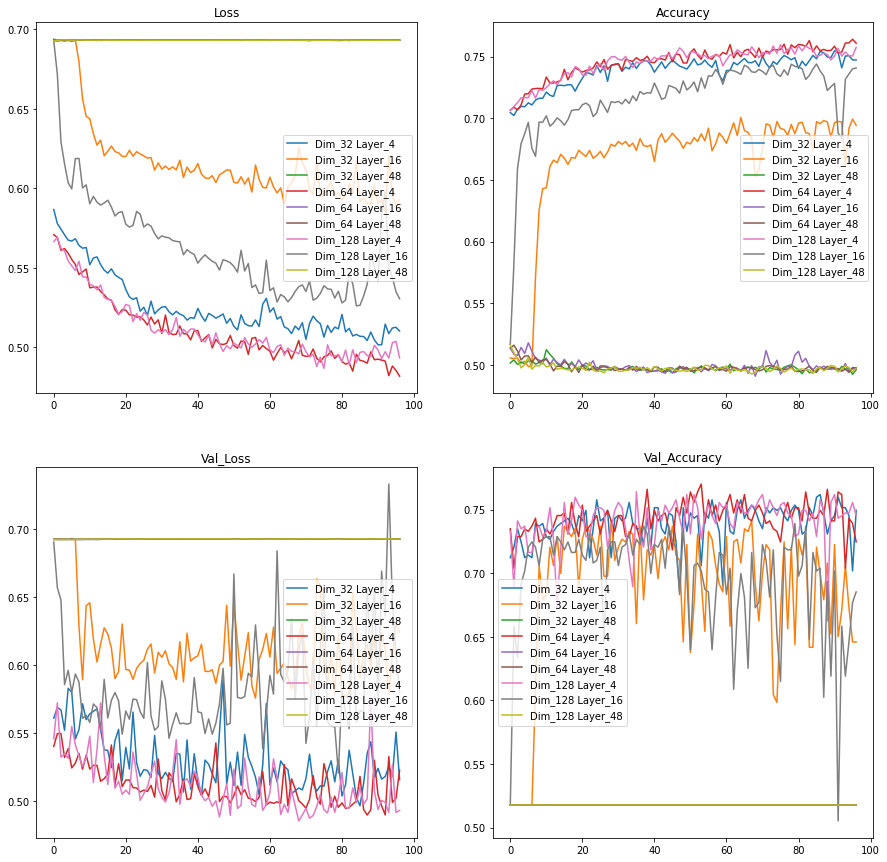

In [16]:
def draw(data):
    legend = list(data[list(data.keys())[0]].keys())
    plt.figure(figsize=(15,15))
    for i, key in enumerate(data):
        plt.subplot(2,2,i+1)
        plt.title(key)
        for item in data[key]:
            plt.plot(data[key][item][3:])
        plt.legend(legend) 
draw(result)

## 仅使用选手数据

In [135]:
def processData(data):
    data = tf.data.Dataset.from_tensor_slices((data[:,1:11],data[:,0]))
    data = data.shuffle(2000).batch(BATCH).prefetch(AUTO)
    return data

player_info = player_info.drop("f_score", axis=1)
val_data = data.sample(frac=VAL_SPLIT)
train_data = data.drop(val_data.index)
val_data = processData(val_data.values)
train_data = processData(train_data.values)

In [149]:
def attention(x):
    atten = tf.matmul(x, x, transpose_a=True)
    atten = tf.nn.softmax(atten, axis=-1)
    x = tf.matmul(x, atten)
    return x

DROPOUT = 0.2
def build_model(num_res, dim):
    players = tf.keras.layers.Input(10, dtype="int32")
    players_ = tf.one_hot(players, depth=PLAYER_EMBED)
    player_emb1 = tf.matmul(players_, player_info.values)
    
    #x = attention(player_emb1)
    
    #x = keras.layers.Bidirectional(keras.layers.LSTM(dim, dropout=DROPOUT))(x)
    x = keras.layers.Flatten()(player_emb1)
    branch = x
    for _ in range(num_res):
        x = resBlock(x, dim)
    x = keras.layers.Dense(x.shape[-1], activation="relu")(x)
    x = keras.layers.ReLU()(x + branch)
    x = keras.layers.Dropout(DROPOUT)(x)

    x = keras.layers.Dense(dim, activation="relu")(x)
    out = tf.keras.layers.Dense(2,activation='softmax')(x)

    return tf.keras.Model(inputs=players,outputs=out)

In [161]:
# 仅选手attention
model2 = build_model(8, 1024)
early_stop = keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001,patience=20,)
model2.compile(optimizer = keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy")
history2 = model2.fit(train_data, validation_data=val_data,epochs=300, callbacks=[early_stop])

Epoch 1/300
272/272 [==============================] - 7s 22ms/step - loss: 0.6445 - accuracy: 0.6476 - val_loss: 0.6159 - val_accuracy: 0.6646
Epoch 2/300
272/272 [==============================] - 5s 20ms/step - loss: 0.6077 - accuracy: 0.6694 - val_loss: 0.5873 - val_accuracy: 0.6915
Epoch 3/300
272/272 [==============================] - 6s 20ms/step - loss: 0.5974 - accuracy: 0.6772 - val_loss: 0.5878 - val_accuracy: 0.7019
Epoch 4/300
272/272 [==============================] - 5s 20ms/step - loss: 0.5966 - accuracy: 0.6746 - val_loss: 0.5628 - val_accuracy: 0.7412
Epoch 5/300
272/272 [==============================] - 5s 20ms/step - loss: 0.5875 - accuracy: 0.6842 - val_loss: 0.5577 - val_accuracy: 0.7308
Epoch 6/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5918 - accuracy: 0.6834 - val_loss: 0.5812 - val_accuracy: 0.7039
Epoch 7/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5866 - accuracy: 0.6886 - val_loss: 0.5493 - val_accuracy:

272/272 [==============================] - 5s 19ms/step - loss: 0.5718 - accuracy: 0.6967 - val_loss: 0.5537 - val_accuracy: 0.7267
Epoch 58/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5718 - accuracy: 0.7006 - val_loss: 0.5537 - val_accuracy: 0.7288
Epoch 59/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5715 - accuracy: 0.7010 - val_loss: 0.5486 - val_accuracy: 0.7474
Epoch 60/300
272/272 [==============================] - 5s 20ms/step - loss: 0.5701 - accuracy: 0.6996 - val_loss: 0.5718 - val_accuracy: 0.7101
Epoch 61/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5732 - accuracy: 0.6966 - val_loss: 0.5585 - val_accuracy: 0.7308
Epoch 62/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5726 - accuracy: 0.7035 - val_loss: 0.5523 - val_accuracy: 0.7205
Epoch 63/300
272/272 [==============================] - 5s 19ms/step - loss: 0.5718 - accuracy: 0.6990 - val_loss: 0.5678 - val_accuracy: 0.712

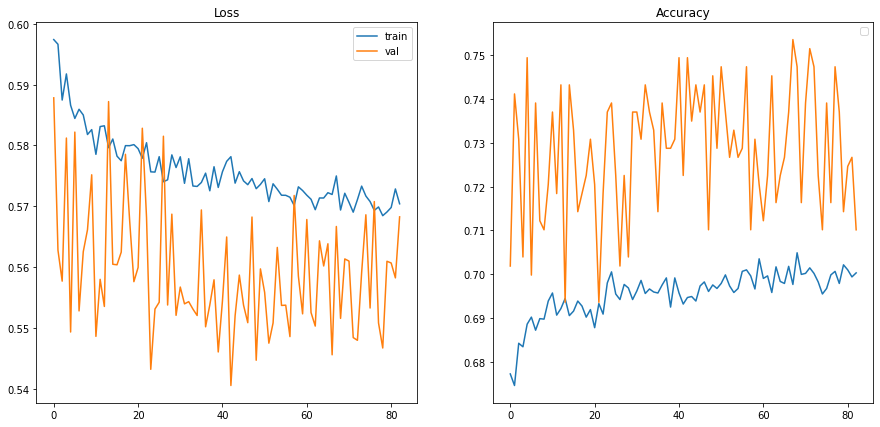

In [164]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history2.history['loss'][2:])
plt.plot(history2.history['val_loss'][2:])
plt.legend(['train', 'val'])       
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.legend(['train', 'val'])    
plt.plot(history2.history['accuracy'][2:])
plt.plot(history2.history['val_accuracy'][2:])


In [165]:
model.save(f"./model/player/model_loss-{history2.history['loss'][-1]:.3f}"
           f"_accuracy-{history2.history['accuracy'][-1]:.3f}"
           f"_valLoss-{history2.history['val_loss'][-1]:.3f}"
           f"_valAccuracy-{history2.history['val_accuracy'][-1]:.3f}.h5")

## 输入数据进行预测